In [3]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
%matplotlib inline

# 1. 커널 서포트 벡터 머신

In [2]:
# 커널 서포트 벡터 머신(kernelized support vector machines, SVM)은 입력 데이터에서
# 단순한 초평면(hyperplane)으로 정의되지 않는 더 복잡한 모델을 만들 수 있도록 확장한 것
# 분류, 회귀에 모두 사용
# SVC를 사용하는 분류 문제만 다뤄보기로 함
# SVR를 사용하는 회귀 문제도 같은 개념 적용 할 수 있음
# SVM의 수학적 정의는 복잡함

# 2. 선형 모델과 비선형 특성

Text(0,0.5,'feature 1')

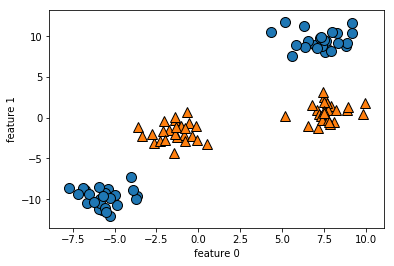

In [4]:
# 직선과 초평면은 유연하지 못하여 저차원 데이터셋에서는 선형 모델이 매우 제한적이다.
# 선형 모델을 유연하게 만드는 한 가지 방법
#  - 특성끼리 곱하거나 특성을 거듭 제곱하는 식으로 새로운 특성 추가하는 것

# 인위적 데이터셋 살펴보기
# 선형적으로 구분되지 않는 클래스를 가진 이진 분류 데이터셋
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("feature 0")
plt.ylabel("feature 1")

Text(0,0.5,'feature 1')

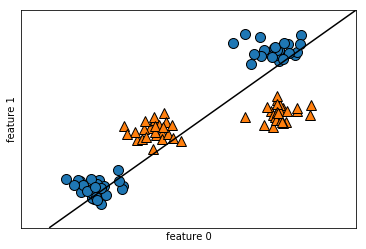

In [8]:
# 분류를 위한 선형 모델은 직선으로만 데이터 포인트를 나눌 수 있어 이런 데이터셋에는
# 잘 맞지 않는다.

from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("feature 0")
plt.ylabel("feature 1")

Text(0.5,0,'feature1 ** 2')

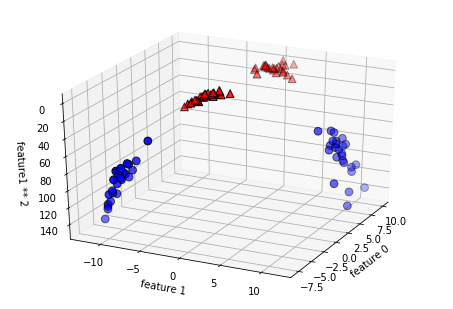

In [15]:
# 두 번째 특성을 제곱한 특성1 ** 2를 새로운 특성으로 추가해 입력 특성 확장
# 이제 2차원 데이터 포인트가 아닌 (특성 0, 특성1, 특성1 ** 2)의 3차원 데이터 포인트로
# 표현됨
# 3차원 산점도 그리기

# 두 번재 특성을 제곱하여 추가
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d

figure = plt.figure()

# 3차원 그래프
ax = Axes3D(figure, elev=-152, azim=-26)

# y == 0인 포인트를 먼저 그리고 그 다음 y == 1인 포인트를 그린다.
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2,
          s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
          cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("feature 0")
ax.set_ylabel("feature 1")
ax.set_zlabel("feature1 ** 2")

# 새로운 데이터셋에서는 선형 모델과 3차원 공간의 평면을 사용해 두 클래스 구분할 수 있다.

Text(0.5,0,'feature1 ** 2')

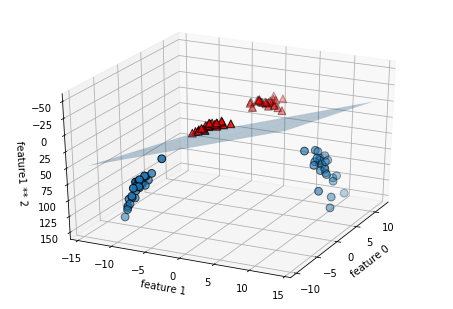

In [23]:
# 확장된 데이터셋에서 선형 모델 만들기

linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 선형 결정 경계 그리기
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], cmap=mglearn.cm2, s=60,
          edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
          cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("feature 0")
ax.set_ylabel("feature 1")
ax.set_zlabel("feature1 ** 2")

Text(0,0.5,'feature 1')

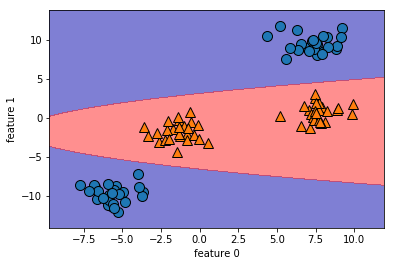

In [30]:
# 원래 특성으로 투영해보면 이 선형 SVM 모델은 더 이상 선형이 아니다.
# 직선보다 타원에 가까운 모습

ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("feature 0")
plt.ylabel("feature 1")

# 3. 커널 기법

In [31]:
# 앞에서 데이터셋에 비선형 특성을 추가하여 선형 모델을 강력하게 만들었지만
# 많은 경우 어떤 특성을 추가해야 할지 모르고 특성을 많이 추가하면(예. 100개의 특성에서
# 모든 조합) 연산 비용이 커진다.

# 커널 기법(kernel trick): 수학적 기교를 사용해서 새로운 특성을 많이 만들지 않고서도
# 고차원에서 분류기를 학습시키는 것
# 실제로 데이터를 확장하지 않고 확장된 특성에 대한 데이터 포인트들의 거리(스칼라곱)를
# 계산한다.

# SVM에서 데이터를 고차원 공간에 매핑하는데 많이 사용하는 방법
# 1) 다항식 커널: 원래 특성의 가능한 조합을 지정된 차수까지 모두 계산
#   (예. 특성1 ** 2 x 특성2 ** 5)
# 2) RBF(radial basis function, 가우시안(Gaussian) 커널): 차원이 무한한 특성 공간에
#   매핑하는 것, 모든 차수의 모든 다항식을 고려
#   하지만 특성의 중요도는 고차항이 될수록 줄어든다.(지수 함수의 테일러 급수 전개 때문)    

# 실제로 커널 SVM 이면의 수학적 이론은 중요하지 않지만,
# RBF 커널을 사용한 SVM이 결정을 만드는 방법은 비교적 쉽게 요약 가능

# 4. SVM 이해하기

In [1]:
# 서포트 벡터(support vector): 두 클래스 사이의 경계에 위치한 데이터 포인트들
# 일반적으로 training data의 일부만 결정 경계를 만드는데 영향을 준다.
# 새로운 데이터 포인트에 대해 예측하려면 각 서포트 벡터와의 거리를 측정한다.
# 분류 결정은 서포트 벡터까지의 거리에 기반하며 서포트 벡터의 중요도는 훈련 과정에서
# 학습한다.(SVC 객체의 dual_coef_ 속성에 저장된다.)

# 데이터 포인트 사이의 거리(가우시안 커널에 의해 계산)
# k_rbf(x_1, x_2) = exp(-γ||x_1 - x_2||^2)
# x_1, x_2: 데이터 포인트
# ||x_1 - x_2||: 유클리디안 거리
# γ(gamma): 가우시안 커널의 폭을 제어하는 매개변수

Text(0,0.5,'feature 1')

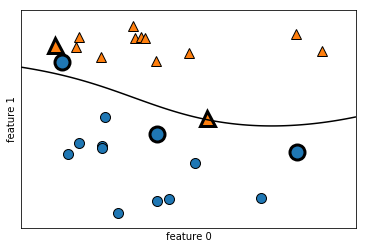

In [11]:
# 두 개 클래스를 가진 2차원 데이터셋에 서포트 벡터 머신 학습시키기

from sklearn.svm import SVC

X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)

mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

# 서포트 벡터
sv = svm.support_vectors_
# dual_coef_의 부호에 의해 서포트 벡터의 클래스 레이블이 결정된다.
sv_labels = svm.dual_coef_.ravel() > 0

# 서포트 벡터 굵은 테두리로 나타내기
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)

plt.xlabel("feature 0")
plt.ylabel("feature 1")

# 결과 SVM은 매우 부드럽고 비선형(직선이 아닌) 경계를 만듬

# 5. SVM 매개변수 튜닝

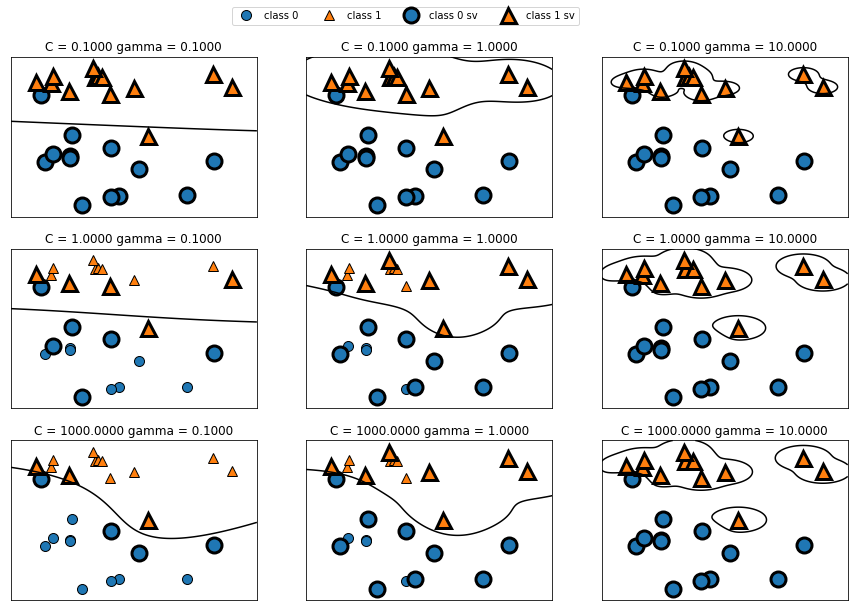

In [13]:
# gamma: 가우시안 커널폭의 역수, 하나의 훈련 샘플이 미치는 영향의 범위를 결정
# 작은 값: 넓은 영역, 큰 값: 영향이 미치는 범위가 제한적
# 다른 말로 가우시안 커널의 반경이 클수록 훈련 샘플의 영향 범위도 커진다.

# * gamma는 0보다 커야하므로 가우시안 커널 함수값의 범위는 e^0 ~ e^-∞, 즉 1 ~ 0 사이
#   따라서 gamma 값이 작을수록 데이터 포인트의 영향 범위가 커진다.

# C: 규제 매개변수, 각 포인트의 중요도를 제한(정확히는 dual_coef_ 값)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)

axes[0, 0].legend(["class 0", "class 1", "class 0 sv", "class 1 sv"], ncol=4, 
                  loc=(.9, 1.2))

# 왼쪽 → 오른쪽: gamma 0.1 → 10
# 작은 gamma값은 가우시안 커널 반경을 크게하여 많은 포인트들이 가까이 있는 것으로 고려
# 따라서 왼쪽 그림의 결정 경계는 매우 부드럽고 오른쪽으로 갈수록 하나의 포인트에 더
# 민감해진다.
# 작은 gamma값이 결정 경계를 천천히 바뀌게 하므로 모델의 복잡도를 낮춘다.
# 큰 gamma값은 더 복잡한 모델을 만든다.

# 위 → 아래: C 0.1 → 1000
# 선형 모델처럼 작은 C는 매우 제약이 큰 모델을 만들고 각 데이터 포인트의 영향력이 작다.
# 왼쪽 위 결정 경계: 거의 선형에 가까우며 잘못 분류된 데이터 포인트가 경계에 거의
#                    영향을 주지 않는다.
# C를 증가시키면 결정 경계를 휘어서 정확하게 분류한다.

In [18]:
# RBF 커널 SVM을 유방암 데이터셋에 적용
# 기본값 C=1, gamma=1/n_feature 사용
# * SVC의 gamma 기본값은 'auto'이며, 특성 개수의 역수(1/X_train.shape[1])를 의미함

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                   random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("training set 정확도: {:.2f}".format(svc.score(X_train, y_train)))
print("test set 정확도: {:.2f}".format(svc.score(X_test, y_test)))

# 과대적합
# SVM은 잘 작동하는 편이지만 매개변수 설정과 데이터 스케일에 매우 민감하다.
# 특히 입력 특성의 범위가 비슷해야 한다.

training set 정확도: 1.00
test set 정확도: 0.63


Text(0,0.5,'feature size')

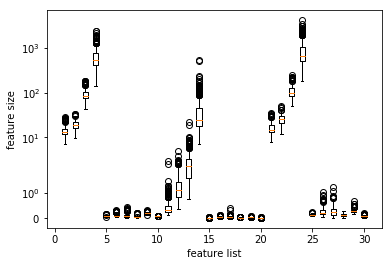

In [22]:
# 각 특성의 최솟값과 최댓값을 로그 스케일로 나타내기

plt.boxplot(X_train, manage_xticks=False)
plt.yscale("symlog")
plt.xlabel("feature list")
plt.ylabel("feature size")

# 6. SVM을 위한 데이터 전처리

In [31]:
# 이 문제를 해결하는 방법
# 1) 특성 값의 범위가 비슷해지도록 조정하는 것
#   - 커널 SVM에서는 모든 특성 값을 0, 1 사이로 맞추는 방법 많이 사용한다.

# training set에서 특성별 최솟값 계산
min_on_training = X_train.min(axis=0)
# training set에서 특성별 (최댓값 - 최솟값) 범위 계산
range_on_training = (X_train - min_on_training).max(axis=0)
# training data에 최솟값을 빼고 범위로 나누면 각 특성에 대해 최솟값은 0, 최대값은 1이다.
X_train_scaled = (X_train - min_on_training) / range_on_training

print("특성별 최소 값\n{}".format(X_train_scaled.min(axis=0)))
print("특성별 최대 값\n{}".format(X_train_scaled.max(axis=0)))

특성별 최소 값
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
특성별 최대 값
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [33]:
# test set에도 적용
# training set에서 계산한 최솟값과 범위 사용
X_test_scaled = (X_test - min_on_training) / range_on_training

svc = SVC()
svc.fit(X_train_scaled, y_train)

print("training set 정확도: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("test set 정확도: {:.3f}".format(svc.score(X_test_scaled, y_test)))

# 데이터 스케일을 조정하니 매우 비슷해서 과소적합

training set 정확도: 0.948
test set 정확도: 0.951


In [36]:
# C나 gamma 값 증가시켜 좀 더 복잡한 모델 만들기

svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("training set 정확도: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("test set 정확도: {:.3f}".format(svc.score(X_test_scaled, y_test)))

# 모델의 성능이 97.2%로 향상됨

training set 정확도: 0.988
test set 정확도: 0.972


# 7. 장단점과 매개변수

In [ ]:
# 장단점
# 커널 서포트 벡터 머신 SVM은 강력한 모델이며 다양한 데이터셋에서 잘 작동한다.
# 데이터 특성이 몇 개 안되도 복잡한 결정 경계를 만들 수 있다.
# 저차원, 고차원 데이터에 모두 잘 작동하지만 샘플이 많을 때는 잘 맞지 않는다.
# 10,000개 샘플 정도면 SVM 모델이 잘 작동하지만
# 100,000개 이상 데이터셋에서는 속도와 메모리 문제가 있을 수 있다.

# 데이터 전처리와 매개변수 설정에 신경을 많이 써야 한다.
# 그래서 전처리가 거의/전혀 없는 트리 기반 모델 랜덤 포레스트나 그래디언트 부스팅을
# 많이 사용
# 분석이 어렵다. 예측이 어떻게 결정되었는지 이해하기 어렵고, 비전문가에게 모델을 
# 설명하기 난해하다.

# 모든 특성이 비슷한 단위이고(예. 모든 값이 픽셀의 컬러 강도) 스케일이 비슷하면 
# SVM을 시도해볼 만하다.

# 매개변수
# 중요한 매개변수는 규제 매개변수 C, 어떤 커널을 사용할지와 각 커널에 따른 매개변수
# RBF 커널의 경우, 가우시안 커널 폭의 역수인 gamma 매개변수 하나를 가진다.
# (γ = 1/2σ^2, 종종 σ가 가우시안 커널의 폭을 조절한다고 말한다.)
# gamma, C 모두 모델의 복잡도를 조정하며 둘 다 큰 값이 더 복잡한 모델을 만든다
# 그러므로 연관성이 많은 이 매개변수를 잘 설정하려면 C, gamma를 함께 조정해야 한다.

# scikit-learn에는 RBF커널 외 다른 커널도 많다.
# * SVC의 kernel 옵션: 'linear'(x1x2), 'poly'(γ(x1x2)+c)d, 'rbf'(기본값), 
#                      'sigmoid'(tanh(γ(x1x2)+c)), 'precomputed'(미리 계산된 거리값을
#                       입력 특성으로 사용하는 경우)
# * c는 coef0, d는 degree 매개변수에서 지정

